# Setup

In [1]:
import json
import os
import sys

sys.path.append('../..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.linear_model import ElasticNet, LogisticRegression

from verde import BlockKFold

from utils import read_csv_non_utf, preprocess_data, get_zero_nonzero_datasets, ratios_to_DI_cats
from model_utils import HurdleModelEstimator

In [2]:
# Loading in general configuration
with open('../../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

In [3]:
# Reading in data as a pandas dataframe
ben_lop2019 = read_csv_non_utf(data_path)

## Helper functions

In [106]:
# A convenience function for plotting the cross-validation from the sklearn user guide:
#  - https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#visualizing-cross-validation-behavior-in-scikit-learn
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw = 10, group_name = None):
    
    """Create a sample plot for indices of a cross-validation object."""

    # Establishing color maps for plotting
    cmap_cv = plt.cm.Set1
    cmap_data = plt.cm.Set3

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X = X, y = y, groups = group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c = indices,
            marker = '_',
            lw = lw,
            cmap = cmap_cv,
            vmin = -0.2,
            vmax = 1.2,
        )

    # Plot the groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c = group, marker = '_', lw = lw, cmap = cmap_data
    )

    # Formatting
    yticklabels = [f'Fold {i}' for i in range(n_splits)] + ['Group' if group_name is None else group_name]
    ax.set(
        yticks = np.arange(n_splits + 1) + 0.5,
        yticklabels = yticklabels,
        xlabel = 'Sample index',
        ylabel = 'CV iteration',
        ylim = [n_splits + 1.2, -0.2],
    )
    ax.set_title('{}'.format(type(cv).__name__), fontsize = 15)
    return ax

# Group-based fold blocking

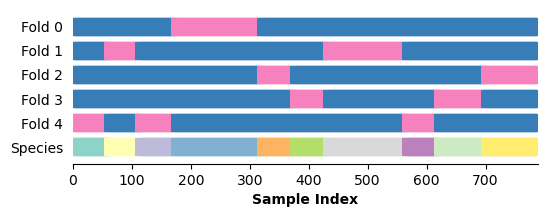

In [110]:
# Visualizing group-based cross-val behavior
group_var = ['Species']
species_subset = ben_lop2019['Species'].value_counts().iloc[ : 10].index

for var in group_var: 
    # data = ben_lop2019.sample(frac = 0.1, random_state = 1693).copy(deep = True)
    if var == 'Species':
        data = ben_lop2019[ben_lop2019['Species'].isin(species_subset)].copy(deep = True)
    else:
        data = ben_lop2019.copy(deep = True)

    #  getting the dataset splits
    data['group'] = LabelEncoder().fit_transform(data[var])
    data = data.sort_values('group')
    
    X = data[['BM', 'DistKm', 'Reserve', 'TravTime']]
    y = ratios_to_DI_cats(data['ratio'])
    groups = data['group']
    
    n_splits = 5
    cv = GroupKFold(n_splits = n_splits)

    #  plotting
    fig, ax = plt.subplots(figsize = (6, 2))
    plot_cv_indices(cv, X, y, groups, ax, n_splits, lw = 13, group_name = var)
    
    ax.set_title('')
    ax.set_xlabel('Sample Index', weight = 'bold')
    ax.set_ylabel('')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.tick_params(axis = 'y', left = False)

    ax.set_xlim(0, len(data))

    # plt.savefig('../../figures/example_species_blocking.pdf', bbox_inches = 'tight')
    plt.show()

In [7]:
# Checking overall class representation
DI_cats = ratios_to_DI_cats(ben_lop2019['ratio'])
DI_cats.value_counts() / len(DI_cats) * 100

ratio
0.0    53.825053
2.0    23.895154
1.0    22.279793
Name: count, dtype: float64

In [8]:
# Checking the class representation across block folds
for var in group_var: 
    print_text = 'BLOCKING ON ' + var.upper()
    print(print_text + '\n' + '-' * len(print_text))
    
    # ben_lop2019['group'] = LabelEncoder().fit_transform(ben_lop2019[var])
    # ben_lop2019 = ben_lop2019.sort_values('group')
    
    X = ben_lop2019[['BM', 'DistKm', 'Reserve', 'TravTime']].values
    y = ratios_to_DI_cats(ben_lop2019['ratio']).values
    # groups = ben_lop2019['group'].values
    groups = ben_lop2019[var].values
    
    n_splits = 5
    cv = GroupKFold(n_splits = n_splits)

    group_members_seen = []
    for train_idx, test_idx in cv.split(X = X, y = y, groups = groups):
        print(f'Train size: {len(train_idx)}')
        cls, counts = np.unique(y[train_idx], return_counts = True)
        
        for c, cnt in zip(cls, counts):
            pct = (cnt / counts.sum()) * 100
            print(f'{round(pct, 1)}% for class {int(c)}')
        print('---')

        group_members_seen.extend(np.unique(groups[test_idx])) # checking which groups were in this test set

    if (len(set(group_members_seen)) == len(group_members_seen)) and (len(group_members_seen) == len(np.unique(groups))):
        print('All groups seen and only seen in one test set!')

    print()

BLOCKING ON ORDER
-----------------
Train size: 2121
54.6% for class 0
21.8% for class 1
23.6% for class 2
---
Train size: 2392
55.0% for class 0
21.5% for class 1
23.5% for class 2
---
Train size: 2857
53.0% for class 0
23.1% for class 1
23.9% for class 2
---
Train size: 2875
52.4% for class 0
22.8% for class 1
24.8% for class 2
---
Train size: 2879
54.5% for class 0
21.9% for class 1
23.5% for class 2
---
All groups seen and only seen in one test set!

BLOCKING ON FAMILY
------------------
Train size: 2624
52.7% for class 0
22.6% for class 1
24.7% for class 2
---
Train size: 2624
54.2% for class 0
21.7% for class 1
24.0% for class 2
---
Train size: 2624
52.8% for class 0
22.9% for class 1
24.4% for class 2
---
Train size: 2626
53.9% for class 0
21.8% for class 1
24.3% for class 2
---
Train size: 2626
55.5% for class 0
22.4% for class 1
22.1% for class 2
---
All groups seen and only seen in one test set!

BLOCKING ON SPECIES
-------------------
Train size: 2625
53.2% for class 0
22.7%

In [9]:
# Checking that behavior is consistent, i.e., there's no randomness involved
n_splits = 5
cv1 = GroupKFold(n_splits = n_splits)
split1 = [(train_idx, test_idx) for train_idx, test_idx in cv1.split(X = X, y = y, groups = groups)]

cv2 = GroupKFold(n_splits = n_splits)
split2 = [(train_idx, test_idx) for train_idx, test_idx in cv2.split(X = X, y = y, groups = groups)]

for i, (c1, c2) in enumerate(zip(split1, split2)):
    print(f'Split {i}')
    print('Differences in train indices:', (c1[0] != c2[0]).sum())
    print('Differences in test indices:', (c1[1] != c2[1]).sum())
    print()

Split 0
Differences in train indices: 0
Differences in test indices: 0

Split 1
Differences in train indices: 0
Differences in test indices: 0

Split 2
Differences in train indices: 0
Differences in test indices: 0

Split 3
Differences in train indices: 0
Differences in test indices: 0

Split 4
Differences in train indices: 0
Differences in test indices: 0



# Spatial fold blocking

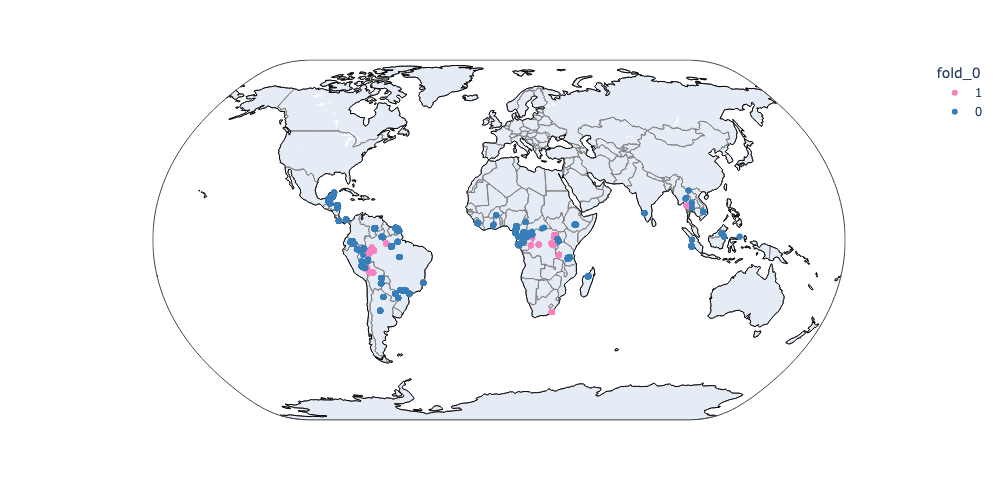

In [87]:
# Testing out verde's spatial blocking capabilities
coords = ben_lop2019[['X', 'Y']].values
bkf = BlockKFold(spacing = 5, n_splits = 5, shuffle = True, random_state = 1693)

idx_fold_num = np.zeros_like(coords[ : , 0])
for i, (train_idx, test_idx) in enumerate(bkf.split(coords)):
    idx_fold_num[test_idx] = i

ben_lop2019['fold_num'] = idx_fold_num.astype(int).astype(str)
ben_lop2019['fold_0'] = (ben_lop2019['fold_num'] == '0').astype(int).astype(str)

# Plotting study locations as a scatterplot
fig = px.scatter_geo(ben_lop2019, 
                     lat = 'Y',
                     lon = 'X',
                     color = 'fold_0',
                     hover_name = 'Reference',
                     width = 1000,
                     height = 500,
                     color_discrete_sequence = ['#f781c0' ,'#377eb8'])
fig.update_geos(showcoastlines = True, coastlinecolor = 'Black',
                showcountries = True, countrycolor = 'Grey',
                projection_type = 'natural earth')
# fig.update_layout(geo = dict(lonaxis = dict(showgrid = True,
#                                             gridwidth = 0.2,
#                                             dtick = 10,
#                                             gridcolor = '#787878'),
#                              lataxis = dict(showgrid = True,
#                                             gridwidth = 0.2,
#                                             dtick = 10, 
#                                             gridcolor = '#787878')))

fig.show()

dpi = 200
fig.write_image('../../figures/example_spatial_split_binary.png', width = 6 * dpi, height = 3 * dpi, scale = 1)

In [45]:
cts = ben_lop2019['fold_num'].value_counts()
[sum([i for i in cts if i != j]) for j in cts]

[2535, 2613, 2638, 2662, 2676]

# Figuring out how to safely copy sklearn models

In [4]:
# Checking out how to safely clone an sklearn model
hm = HurdleModelEstimator(zero_model = LogisticRegression(C = 10.0), nonzero_model = ElasticNet())

#  checking memory sameness: fit one model but not the other...
pp_data = preprocess_data(ben_lop2019, include_indicators = False, standardize = True, log_trans_cont = False,
                          polynomial_features = 0)
hm.fit(pp_data)

hm_clone = clone(hm)
print('Same hurdle models in memory?', hm is hm_clone)
print('Same zero model in memory?', hm.zero_model is hm_clone.zero_model)
print('Same nonzero model in memory?', hm.nonzero_model is hm_clone.nonzero_model)
print()

try:
    hm.zero_model.coef_
    print('Original has fitted coefficients')
except AttributeError:
    print('Original DOESN\'T have fitted coefficients')

try:
    hm_clone.zero_model.coef_
    print('Copy has fitted coefficients')
except AttributeError:
    print('Copy DOESN\'T have fitted coefficients')

Same hurdle models in memory? False
Same zero model in memory? False
Same nonzero model in memory? False

Original has fitted coefficients
Copy DOESN'T have fitted coefficients


# Miscellaneous testing

In [20]:
# Checking that I get the same indices if I split twice with a single KFold object w/random state
kfold = KFold(n_splits = 5, random_state = 1693, shuffle = True)

a = list(kfold.split(ben_lop2019))
b = list(kfold.split(ben_lop2019))

for i, j in zip(a, b):
    print((i[0] != j[0]).sum())
    print((i[1] != j[1]).sum())
    print()

0
0

0
0

0
0

0
0

0
0



In [32]:
a = pd.DataFrame({'a' : [1, 2, 3], 'b' : [4, 5, 6]})
b = a.copy(deep = True)[['b', 'a']]

pd.concat((a, b), axis = 0)

,a,b
0,1,4
1,2,5
2,3,6
0,1,4
1,2,5
2,3,6


In [33]:
a

,a,b
0,1,4
1,2,5
2,3,6


In [34]:
b

,b,a
0,4,1
1,5,2
2,6,3
